<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220820.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta

import re
import os 

from functools import reduce 
from collections import defaultdict, Counter, ChainMap

# customer analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'sample_data']

In [16]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 'Transactions')
df.head()

,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145


In [17]:
df.columns = df.iloc[0]
df.drop([0], axis = 0, inplace = True)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [18]:
df = df[df.order_status == 'Approved']
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [21]:
df.transaction_date = df.transaction_date.to_numpy().astype('datetime64[ns]')
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df.transaction_date.to_numpy().astype('datetime64[M]')

df = df[['customer_id', 'date','month', 'list_price']].rename(columns = {'customer_id':'id','list_price':'rev'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

,id,date,month,rev
0,1,2017-01-05,2017-01-01,360.4
1,1,2017-02-21,2017-02-01,71.49
2,1,2017-03-27,2017-03-01,688.63
3,1,2017-03-29,2017-03-01,1274.93
4,1,2017-04-06,2017-04-01,1577.53


In [45]:
df_ = df.assign(week = lambda x : x['date'] - x['date'].dt.weekday.astype('timedelta64[D]')
                ).assign(days = lambda x : (x['date'] - x['week']).dt.days
                         ).reindex(['id', 'week', 'days', 'rev'], axis = 1)
df_ = df_.sort_values(['week', 'id', 'days'])
df_.head()

,id,week,days,rev
307,51,2016-12-26,6,1231.15
653,113,2016-12-26,6,575.27
708,123,2016-12-26,6,1636.9
793,138,2016-12-26,6,544.05
1341,234,2016-12-26,6,1977.36


In [46]:
df_ = df_.groupby(['week', 'days'])['rev'].count().reset_index().rename(columns = {'rev':'pu'})
df_.head()

,week,days,pu
0,2016-12-26,6,51
1,2017-01-02,0,46
2,2017-01-02,1,56
3,2017-01-02,2,58
4,2017-01-02,3,61


In [47]:
df_ = df_.assign(ratio = df_.groupby(['week'])['pu'].apply(lambda x : round(x/x.max()*100,2)),
                 week = df_['week'].astype(str)
                 )
df_ = pd.melt(df_, id_vars = ['week', 'days'], var_name = 'type')
df_.head()

,week,days,type,value
0,2016-12-26,6,pu,51.0
1,2017-01-02,0,pu,46.0
2,2017-01-02,1,pu,56.0
3,2017-01-02,2,pu,58.0
4,2017-01-02,3,pu,61.0


/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_smooth.py:206: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


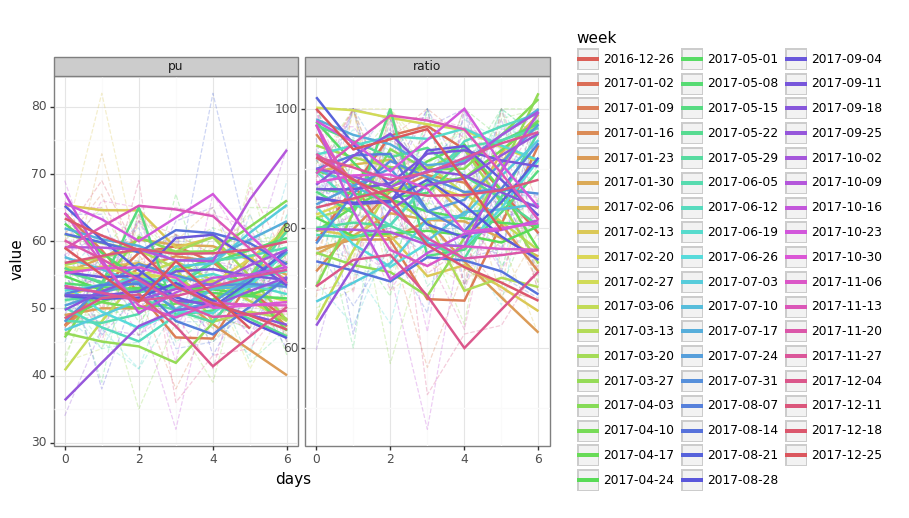

<ggplot: (8766713831481)>

In [48]:
(
    ggplot(df_, aes('days', 'value', color = 'week')) + 
    gg.geom_line(alpha = .3, linetype = 'dashed') + 
    gg.geom_smooth(se = False) +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

In [49]:
df_['days'].max()

6

# iterator

In [51]:
mat = [list('ABC'), list('DEF'), list('GHI')]
[f'({r}, {c})-{letters}' for r, rows in enumerate(mat) for c, letters in enumerate(rows) ]

['(0, 0)-A',
 '(0, 1)-B',
 '(0, 2)-C',
 '(1, 0)-D',
 '(1, 1)-E',
 '(1, 2)-F',
 '(2, 0)-G',
 '(2, 1)-H',
 '(2, 2)-I']

In [52]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [53]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}